This is a place to test things and mess around.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as scop

In [122]:
trainset = pd.read_csv('train.csv', index_col = 'Id')
testset = pd.read_csv('test.csv', index_col = 'Id')

In [33]:
trainset.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [34]:
nullratio = trainset.isnull().sum() / trainset.shape[0]

In [35]:
nullratio[nullratio.values > 0]

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

Lots of missing records. Some features like Alley has a lot of NaN that indicates no alley access so the NaNs are not missing information. NaNs like those will be filled with appropriate values in digitizing the features. There are a few features with real missing information, like LotFrontage or Eletrical. Those NaN needs to be filled or those features can't be used. 

A lot of features consists of discrete data type, like MSSubClass, where the values may needs to be remapped to improve the model. Those features needs to be analyzed and possibly mapped into different features to be used in the model.

Below I examine each feature and process them to be ready for modeling.

In [98]:
aggvals = {'mean', 'std', 'count'}
a = trainset.groupby('MSSubClass').SalePrice.agg(aggvals).sort_values(by = 'mean')
a

,std,count,mean
MSSubClass,,,
30,24857.110069,69,95829
180,29474.282570,10,102300
45,20231.723876,12,108591
190,35439.097661,30,129613
90,27833.249182,52,133541
160,34587.542266,63,138647
50,54851.983702,144,143302
85,19629.942206,20,147810
40,75747.799744,4,156125


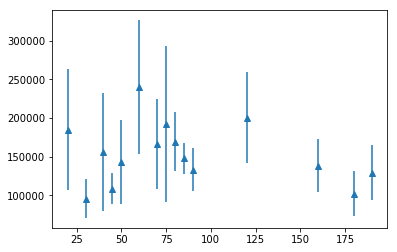

In [37]:
plt.errorbar(a.index, a['mean'], a['std'], linestyle = 'None', marker = '^')
plt.show()

Certain dwelling types have a very well defined narrow band while a few, like class 75: 2-1/2 story all ages have a relatively wide range of prices.

In [38]:
a = trainset.groupby('MSZoning').SalePrice.agg(aggvals)
a

,std,count,mean
MSZoning,,,
C (all),33791.092021,10,74528
FV,52369.662067,65,214014
RH,35714.118427,16,131558
RL,80766.341319,1151,191004
RM,48521.689830,218,126316


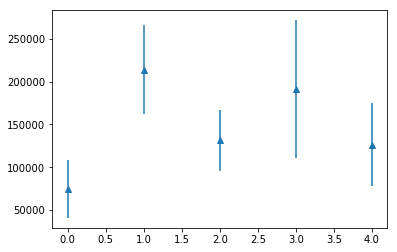

In [39]:
plt.errorbar(range(0, a.shape[0]), a['mean'], a['std'], linestyle = 'None', marker = '^')
plt.show()

Most of the records are in RL: residential low density. The few that are in other categories like Commercial have a relatively narrow range of distribution. It suggests that the feature on its own is not going to be useful in separating most of the houses apart. However, it can be useful when combined with other features.

In [49]:
uzone = trainset.MSZoning.unique()
uzonemap = dict(zip(uzone, range(0, uzone.size)))

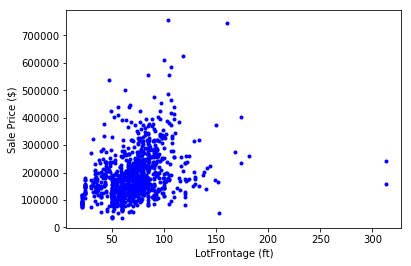

In [43]:
plt.plot(trainset.LotFrontage, trainset.SalePrice, '.b')
plt.xlabel('LotFrontage (ft)')
plt.ylabel('Sale Price ($)')
plt.show()

In [42]:
trainset[['LotFrontage', 'SalePrice']].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.351799
SalePrice,0.351799,1.000000


The linear feet of street connected to property has a decent correlation coefficient with the sales price. About 18% of the data in the training set is missing this information. The plot above suggests there might be at least two sub trends, one with sale price increasing much faster with LotFrontage and the other with a gentler slope between the two. This observation suggests that combining features could improve correlation to sales price. In this case, if we can find a feature that normalized the two trends and collapses them into one the correlation between the normalized LotFrontage and sales price can be greatly improved. So far it seems the subclass or the zoning are not the normalizing factor.

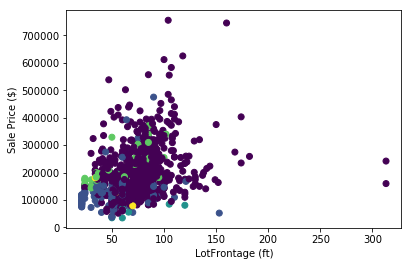

In [51]:
plt.scatter(trainset.LotFrontage, trainset.SalePrice, c = trainset.MSZoning.map(uzonemap))
plt.xlabel('LotFrontage (ft)')
plt.ylabel('Sale Price ($)')
plt.show()

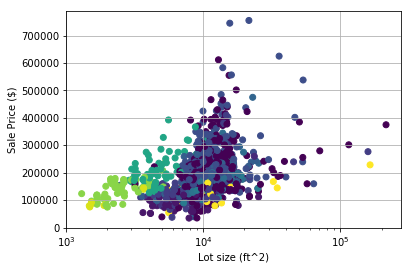

In [94]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.MSSubClass)
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

In [129]:
trainset[['LotArea', 'SalePrice']].corr()

,LotArea,SalePrice
LotArea,1.000000,0.263843
SalePrice,0.263843,1.000000


The lot size has a wide range in the database, therefore it is more appropriate to use its logarithmic value to correlate to the sales price. The figure above shows that depending on the type of dwelling (MSSubClass), the price has different trends with $log(LotSize)$.

With the few features we examined it seems the discrete features can be used to classifity different trends the continuous features has with sales price.

In [70]:
trainset.groupby('Street').SalePrice.agg(aggvals)

,std,count,mean
Street,,,
Grvl,65446.253988,6,130190
Pave,79446.597315,1454,181130


Paved roas access seems to boost the housing price compared to gravel access. However, the sample size for the gravel access houses is very small (6). It is entirely possible the difference is biased and not appropriate to be generalized. The table belows shows those 6 records. It seems though they do represent the average house well up to the LotArea feature. We will keep this feature in mind but for now it is likely we are going to leave it out.

In [72]:
trainset[trainset.Street == 'Grvl']

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
53,90,RM,110.0,8472,Grvl,NaN,IR2,Bnk,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,110000
336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
583,90,RL,81.0,11841,Grvl,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,118500
813,20,C (all),66.0,8712,Grvl,NaN,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,Shed,54,6,2010,WD,Alloca,55993
1062,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1185,20,RL,50.0,35133,Grvl,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,186700


In [76]:
ualley = trainset.Alley.unique()
alleymap = dict(zip(ualley, range(-1, ualley.size-1)))
trainset.groupby(trainset.Alley.map(alleymap)).SalePrice.agg(aggvals)

,std,count,mean
Alley,,,
-1,80667.145177,1369,183452
0,34780.780727,50,122219
1,38370.375239,41,168000


The NAs in alley access type means no access so we map the NaNs into -1 to obtain statistics. Houses with alley access takes a small fraction of the total training set. 

In [87]:
(testset.isnull().sum() / testset.shape[0]).Alley

0.92666209732693627

And so is the case in the test set. As a result, we ignore the Alley feature for now. We may revisit it later for fine tuning the model for houses with alley access. Below we start a record for features we want to use, separated into discrete and continous feature sets.

In [137]:
feats_disc = ['MSSubClass', 'MSZoning']
feats_cont = ['LotFrontage', 'LotArea']

In [89]:
trainset.groupby('LotShape').SalePrice.agg(aggvals)

,std,count,mean
LotShape,,,
IR1,85858.489557,484,206101
IR2,99669.427359,41,239833
IR3,82540.334855,10,216036
Reg,69673.427209,925,164754


Lot shape is an interesting feature. It is not clear what regular means but it seems irregular lots usually fetches higher prices. The IR2 and IR3 both has small sample sizes.

In [95]:
trainset.groupby(['LotShape', 'MSSubClass']).LotShape.agg('count')

LotShape  MSSubClass
IR1       20            201
          30             11
          45              1
          50             27
          60            143
          70             13
          75              2
          80             29
          85             10
          90             10
          120            30
          160             4
          190             3
IR2       20             14
          50              3
          60             19
          75              1
          90              1
          120             2
          160             1
IR3       20              4
          30              1
          60              5
Reg       20            317
          30             57
          40              4
          45             11
          50            114
          60            132
          70             47
          75             13
          80             29
          85             10
          90             41
          120            55

In [101]:
ulots = trainset.LotShape.unique()
lotshapemap = dict(zip(ulots, range(0, ulots.size)))
trainset.groupby('LotShape').LotArea.agg(aggvals)

,std,count,mean
LotShape,,,
IR1,9279.619227,484,11894.545455
IR2,29138.010090,41,23733.658537
IR3,63129.108967,10,41338.200000
Reg,3873.766772,925,8876.915676


It seems that the reason could be irregular lots usually have larger lot area, which generally corresponds to higher prices. The irregular houses also has a higher proportion of high-price types of dwelling (MSSubClass) like type 60: 2-STORY 1946 & NEWER. It seems that the LotShape feature could be represented by other features already in the feature set. The figure below also shows it is not a good classifier for potentially different trends between other continous features. Therefore we ignore this feature for now. If we ever want to use this feature we may need to combine some categories like all IRs together since the sample size of IR2 and IR3 are relatively small.

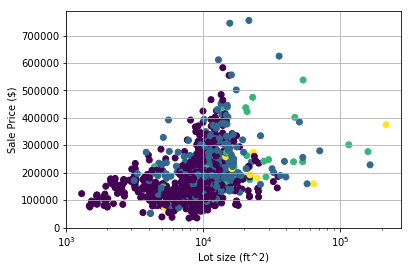

In [104]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.LotShape.map(lotshapemap))
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

In [143]:
def generatemap(col):
    uvals = col.unique()
    return dict(zip(uvals, range(1, uvals.size + 1)))

In [130]:
landcontmap = generatemap(trainset.LandContour)
trainset.groupby('LandContour').SalePrice.agg(aggvals)

,std,count,mean
LandContour,,,
Bnk,49361.244069,63,143104
HLS,101790.139739,50,231533
Low,83935.353618,36,203661
Lvl,78463.567915,1311,180183


Similar to Alley access feature, the land contour has a small number of outliers that are not near flat with the majority of the houses with near flat countours and the mean sales price close to mean sales price for all houses. 

In [134]:
trainset.groupby('LandContour').LotArea.agg(aggvals)

,std,count,mean
LandContour,,,
Bnk,11620.246512,63,11836.888889
HLS,23032.507896,50,15264.640000
Low,44323.418020,36,33075.250000
Lvl,4069.307189,1311,9652.863463


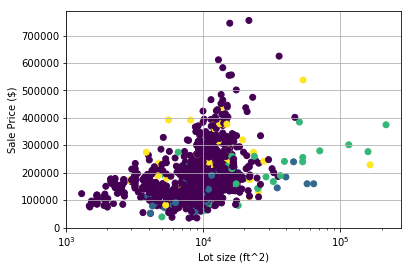

In [133]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.LandContour.map(landcontmap))
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

It does seem the LandContour can be used as a classifier for different lot size vs. sales price relationship. Furthermore, it doesn't seem that the price for a certtain contour type is not necessarily because of its correlation to the lot size or other features we examined so far. As a result, we add it to the discrete feature list.

In [138]:
feats_disc.append('LandContour')

['MSSubClass', 'MSZoning', 'LandContour']

In [139]:
trainset.groupby('Utilities').SalePrice.agg(aggvals)

,std,count,mean
Utilities,,,
AllPub,79461.599814,1459,180950
NoSeWa,NaN,1,137500


Since all the data entries except for one in the training set has AllPub utility type, this feature is not useful in predicting house price with the current training set. We leave it out of future models.

In [149]:
trainset.groupby('LotConfig')[['SalePrice', 'LotArea']].agg(aggvals)

SalePrice                     LotArea                    
                    std count    mean           std count          mean
LotConfig                                                              
Corner     84466.041218   263  181623  11020.980129   263  11426.231939
CulDSac    93117.546585    94  223854  20157.350917    94  17342.053191
FR2        62788.926826    47  177934   4970.987226    47  10398.276596
FR3        78379.222374     4  208475   5656.072401     4   8706.250000
Inside     76426.805782  1052  176938   8113.388256  1052   9691.799430

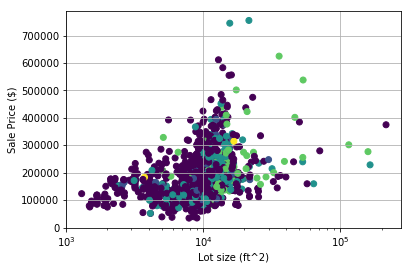

In [146]:
lotconfigmap = generatemap(trainset.LotConfig)
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.LotConfig.map(lotconfigmap))
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

In [152]:
np.corrcoef(trainset.SalePrice, trainset.LotConfig.map(lotconfigmap))

array([[ 1.        ,  0.10910587],
       [ 0.10910587,  1.        ]])

In [154]:
trainset.groupby(['LotConfig', 'MSSubClass']).LotConfig.agg('count')

LotConfig  MSSubClass
Corner     20             99
           30             13
           40              1
           45              3
           50             31
           60             58
           70             12
           75              5
           80             11
           85              4
           90             10
           120             5
           160             5
           190             6
CulDSac    20             40
           50              4
           60             32
           80              6
           85              5
           90              1
           120             5
           160             1
FR2        20             18
           30              1
           50              3
           60             10
           80              5
           90              2
           120             4
           160             4
FR3        20              1
           70              1
           120             1
           160       

It seems that sales price can be correlated to the LotConfig feature. Furthermore, the correlation can't seem to be explained by other features we already explored. So it is added to the discete feature set.

In [155]:
feats_disc.append('LotConfig')

In [156]:
trainset.groupby('LandSlope')[['SalePrice', 'LotArea']].agg(aggvals)

SalePrice                     LotArea                    
                    std count    mean           std count          mean
LandSlope                                                              
Gtl        78669.369147  1382  179956   4639.070058  1382   9780.305355
Mod        92375.358116    65  196734  13207.937689    65  14799.415385
Sev        86729.922409    13  204379  70981.147546    13  67401.923077

In [158]:
trainset.groupby(['LandSlope', 'LandContour']).SalePrice.agg('count')

LandSlope  LandContour
Gtl        Bnk              47
           HLS              32
           Low               9
           Lvl            1294
Mod        Bnk              15
           HLS              16
           Low              18
           Lvl              16
Sev        Bnk               1
           HLS               2
           Low               9
           Lvl               1
Name: SalePrice, dtype: int64

The LandSlope feature is not the same as LandContour feature. It seems steeper slope is correlated to higher sale prices. But it could be because steeper slopes are correlated to larger lot size. The plot below shows that those with steeper slops have a larger average lot size. Those with sever slope seems to form a distinct lot size vs. sale price trend. But the feature LandContour was able to performce similarly. Therefore we leave LandSlope out for now and may revisit it later.

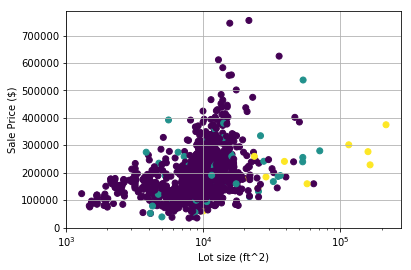

In [159]:
landslopemap = generatemap(trainset.LandSlope)
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.LandSlope.map(landslopemap))
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

In [163]:
trainset.groupby('Neighborhood')['SalePrice'].agg(aggvals).sort_values(by = 'mean')

,std,count,mean
Neighborhood,,,
MeadowV,23491.049593,17,98576
IDOTRR,33376.710113,37,100123
BrDale,14330.176482,16,104493
BrkSide,40348.689260,58,124834
Edwards,43208.616456,100,128219
OldTown,52650.583178,113,128225
Sawyer,22345.129156,74,136793
Blueste,19091.883092,2,137500
SWISU,32622.917665,25,142591


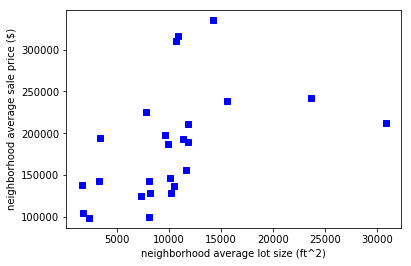

In [168]:
plt.plot(trainset.groupby('Neighborhood').LotArea.agg('mean'), trainset.groupby('Neighborhood').SalePrice.agg('mean'), 'sb')
plt.ylabel('neighborhood average sale price ($)')
plt.xlabel('neighborhood average lot size (ft^2)')
plt.show()

In [170]:
neighbormap = generatemap(trainset.Neighborhood)
np.corrcoef(trainset.SalePrice, trainset.Neighborhood.map(neighbormap))

array([[ 1.        , -0.14362115],
       [-0.14362115,  1.        ]])

As expected, neighborhood can determine the house price. It may be loosely related to lot area but clearly given a similar lot size the neighborhood can be an important factor in determining the sale price. As a result, we add it to the discrete feature list.

In [171]:
feats_disc.append('Neighborhood')

In [172]:
trainset.groupby('Condition1').SalePrice.agg(aggvals)

,std,count,mean
Condition1,,,
Artery,66226.660545,48,135091
Feedr,42157.290105,81,142475
Norm,81256.980119,1260,184495
PosA,52348.932310,8,225875
PosN,65256.536607,19,215184
RRAe,24030.813553,11,138400
RRAn,66177.922066,26,184396
RRNe,5303.300859,2,190750
RRNn,93823.238060,5,212400


It seems that near or adjacent to positive features promotes the sale price while adjacent to street, either artery or feeder, reduces sale price.

In [173]:
trainset.groupby('Condition1').LotArea.agg(aggvals)

,std,count,mean
Condition1,,,
Artery,4686.631946,48,10001.333333
Feedr,8306.278047,81,10729.604938
Norm,10410.488749,1260,10417.626984
PosA,5481.137108,8,16612.375000
PosN,7388.352049,19,12732.842105
RRAe,3365.637681,11,11713.727273
RRAn,4587.704110,26,11982.500000
RRNe,114.551299,2,9372.000000
RRNn,2058.391605,5,9046.800000


It seems the difference is not likely due to lot sizes as shown in the table above. Most conditions have a very similar average lot size. With a few exceptions, mostly in those with positive features. House adjacent to E-W railraod has a much lower average sale price than those adjacent to the N-S railroad. The table below shows the reason could be those adjacent to N-S railroad are mostly 2-STORY 1946 & NEWER, the type with the highest average sale price. This feature may be influenced by MSSubClass a little bit but it contains valuable independent information, like positive features, to be considered in predictive models.

In [176]:
trainset.groupby(['Condition1', 'MSSubClass']).SalePrice.agg('count')

Condition1  MSSubClass
Artery      20              4
            30              5
            45              1
            50             21
            60              1
            70              6
            75              3
            80              1
            90              3
            190             3
Feedr       20             32
            30              6
            45              1
            50             13
            60              8
            70              4
            80              3
            85              1
            90             10
            190             3
Norm        20            473
            30             57
            40              3
            45              9
            50            108
            60            262
            70             46
            75             12
            80             53
            85             18
            90             36
            120            87
            160  

In [178]:
trainset.groupby(['Condition1', 'Condition2']).SalePrice.agg(aggvals)

std  count    mean
Condition1 Condition2                              
Artery     Artery       16263.455967      2  106500
           Norm         61751.796032     45  132142
           PosA                  NaN      1  325000
Feedr      Feedr                 NaN      1   85000
           Norm         41738.486850     76  143883
           RRAe                  NaN      1  190000
           RRAn                  NaN      1  136905
           RRNn         39951.533137      2   96750
Norm       Norm         81256.980125   1260  184495
PosA       Norm         52348.932313      8  225875
PosN       Norm         53470.236361     17  206985
           PosN        141598.132933      2  284875
RRAe       Norm         24030.813553     11  138400
RRAn       Feedr        36771.818920      4  128500
           Norm         65705.473386     22  194559
RRNe       Norm          5303.300859      2  190750
RRNn       Feedr                 NaN      1  128000
           Norm         93642.938869      4  233500

The table above confirms that some conditions are negative ones (Artery, Feedr, RRAe, RRAn) that reduces sale price, and others are positive features. We would like to use the conditions in predictive models. One way to map them into numerical values is to map Norm to 0, the negative ones as negative numbers depending on their mean sale price difference from the Norm ones, and the positive ones as positive numbers.

In [185]:
a = trainset.groupby('Condition1').SalePrice.agg('mean')
a = a - a.loc['Norm']
condmap = a / (np.abs(a)).max()
condmap

Condition1
Artery   -1.000000
Feedr    -0.850538
Norm      0.000000
PosA      0.837584
PosN      0.621185
RRAe     -0.933022
RRAn     -0.002004
RRNe      0.126609
RRNn      0.564833
Name: SalePrice, dtype: float64